### Import labraries to use

In [215]:
from PIL import Image
from skimage.feature import local_binary_pattern, hog, greycomatrix, greycoprops
from skimage.filters import gabor_kernel
from skimage import data
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy import ndimage, linalg
from tqdm import tqdm
from heapq import heappush, heappushpop
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

### Classes to extract features: LBP, HOG, Gabor, Haralick

In [12]:
class LocalBinaryPatterns:
    def __init__(self, P=8, R=2):
        self.P = P
        self.R = R
        self.bins = np.arange(0, 60) - 0.5
        self.bins[-1] = 255.5
    def describe(self, image, eps=1e-7):
        lbp = local_binary_pattern(image, self.P, self.R)
        (hist, _) = np.histogram(lbp.ravel(), bins=self.bins)
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

class HOG:
    def __init__(self, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1)):
        self.ori = orientations
        self.ppc = pixels_per_cell
        self.cpb = cells_per_block
    def describe(self, image):        
        return hog(image,
                   orientations=self.ori,
                   pixels_per_cell=self.ppc,
                   cells_per_block=self.cpb)

class Gabor:
    def __init__(self, theta_range=8, sigmas=(1,3), frequencies=(0.05, 0.25)):
        kernels = []
        for theta in range(theta_range):
            theta = theta / 4. * np.pi
            for sigma in sigmas:
                for frequency in frequencies:
                    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                                  sigma_x=sigma, sigma_y=sigma))
                    kernels.append(kernel)
        self.kernels = kernels
    
    def describe(self, image):
        feats = np.zeros((len(self.kernels) * 2,), dtype=np.double)
        for k, kernel in enumerate(self.kernels):
            filtered = ndimage.convolve(image, kernel, mode='wrap')
            feats[2*k] = filtered.mean()
            feats[2*k+1] = filtered.var()
        return feats
    
class Haralick:
    def __init__(self, distances=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
        self.distances = distances
        self.angles = angles
        self.n = len(distances) * len(angles)
        self.props = ('contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation')
    def describe(self, image):
        glcm = greycomatrix(image, distances=self.distances, angles=self.angles,
                            levels=256, symmetric=True, normed=True)
        feats = np.empty((self.n * 6,), dtype=np.double)
        for i, prop in enumerate(self.props):
            feats[i * self.n : (i+1) * self.n] = greycoprops(glcm, prop).ravel()
        return feats

### Function to extract features for each image from a given folder

In [13]:
def extract_features(img_folder_path):
    _lbp = LocalBinaryPatterns()
    _hog = HOG()
    _gabor = Gabor()
    _haralick = Haralick()
    featmat = None
    img_paths = glob.glob(img_folder_path + '*.png')
    print(img_folder_path, ': %d images found' % len(img_paths))
    for i, imgpath in tqdm(enumerate(img_paths)):
        img = Image.open(imgpath)
        img_gray = img.convert('L')
        lbp_feat = _lbp.describe(img_gray)
        hog_feat = _hog.describe(img)
        gab_feat = _gabor.describe(img_gray)
        har_feat = _haralick.describe(np.asarray(img_gray).copy())
        feat_list = (lbp_feat, hog_feat, gab_feat, har_feat)
        feat_size = sum(len(x) for x in feat_list)
        if featmat is None:
            featmat = np.empty((len(img_paths), feat_size))
            print("featmat.shape = ", featmat.shape)
        offset = 0
        for feat in feat_list:
            featmat[i][offset:offset+len(feat)] = feat
            offset += len(feat)
    return featmat

### Extract and save Test features

In [19]:
feat_test_0 = extract_features('./test/class_0/')

1it [00:00,  8.91it/s]

./test/class_0/ : 420 images found
featmat.shape =  (420, 323)


420it [00:33, 12.36it/s]


In [24]:
np.save('feat_test_0.npy', feat_test_0)

In [25]:
feat_test_1 = extract_features('./test/class_1/')

2it [00:00, 10.99it/s]

./test/class_1/ : 420 images found
featmat.shape =  (420, 323)


420it [00:34, 12.28it/s]


In [26]:
np.save('feat_test_1.npy', feat_test_1)

In [27]:
feat_test_2 = extract_features('./test/class_2/')

2it [00:00, 12.30it/s]

./test/class_2/ : 420 images found
featmat.shape =  (420, 323)


420it [00:34, 12.34it/s]


In [28]:
np.save('feat_test_2.npy', feat_test_2)

### Extract and save Train features

In [29]:
feat_train_0 = extract_features('./train/class_0/')

2it [00:00, 11.92it/s]

./train/class_0/ : 1680 images found
featmat.shape =  (1680, 323)


1680it [02:16, 12.31it/s]


In [30]:
np.save('feat_train_0.npy', feat_train_0)

In [31]:
feat_train_1 = extract_features('./train/class_1/')

2it [00:00, 11.85it/s]

./train/class_1/ : 1680 images found
featmat.shape =  (1680, 323)


1680it [02:16, 12.32it/s]


In [32]:
np.save('feat_train_1.npy', feat_train_1)

In [33]:
feat_train_2 = extract_features('./train/class_2/')

2it [00:00, 12.32it/s]

./train/class_2/ : 1680 images found
featmat.shape =  (1680, 323)


1680it [02:16, 12.33it/s]


In [34]:
np.save('feat_train_2.npy', feat_train_2)

### Load saved features

In [35]:
feat_train_0 = np.load('./feat_train_0.npy')
feat_train_1 = np.load('./feat_train_1.npy')
feat_train_2 = np.load('./feat_train_2.npy')
feat_test_0 = np.load('./feat_test_0.npy')
feat_test_1 = np.load('./feat_test_1.npy')
feat_test_2 = np.load('./feat_test_2.npy')

### Normalize features (z-score) and compute patch labels

In [36]:
feat_train = np.concatenate((feat_train_0, feat_train_1, feat_train_2), axis=0)
feat_mean = feat_train.mean(0)
feat_std = feat_train.std(0)
feat_train = (feat_train - feat_mean) / feat_std

In [45]:
labels_train = np.array([0] * feat_train_0.shape[0] +\
                        [1] * feat_train_1.shape[0] +\
                        [2] * feat_train_2.shape[0])

In [140]:
feat_test = np.concatenate((feat_test_0, feat_test_1, feat_test_2), axis=0)
feat_test = (feat_test - feat_mean) / feat_std

In [47]:
labels_test = np.array([0] * feat_test_0.shape[0] +\
                       [1] * feat_test_1.shape[0] +\
                       [2] * feat_test_2.shape[0])

### Compute "patch group" labels

In [162]:
class PatchGroup:
    def __init__(self, label):
        self.indexes = []
        self.label = label
        
def get_patch_groups(category):
    offset = 0
    groups = dict()
    for label in (0, 1, 2):        
        paths = glob.glob('./%s/class_%d/*.png' % (category, label))
        for i, path in enumerate(paths):
            k = path[:-8]
            try:
                g = groups[k]
            except KeyError:
                g = groups[k] = CropsGroup(label)
            g.indexes.append(offset + i)
        offset += len(paths)
    return list(groups.values())

In [163]:
test_groups = get_patch_groups('test')
test_group_labels = [g.label for g in test_groups]

In [164]:
train_groups = get_patch_groups('train')
train_group_labels = [g.label for g in train_groups]

### some utility functions 

In [157]:
def get_accuracy(pred_labels, test_labels):
    return sum(x == y for x,y in zip(test_labels, pred_labels)) / len(test_labels)
    
def get_pred_group_labels(pred_labels, test_groups):
    pred_group_labels = []
    for g in test_groups:
        counts = dict()
        for i in g.indexes:
            counts[pred_labels[i]] = counts.get(pred_labels[i], 0) + 1
        g_pred = max((f,k) for k,f in counts.items())[1]
        pred_group_labels.append(g_pred)
    return pred_group_labels

In [196]:
def plot_confusion_matrix(y_test, y_pred):
    classes = ('NORMAL', 'NEUMONIA', 'COVID19')
    n = len(classes)
    matrix = np.zeros((n,n),dtype=np.int32)
    for a, b in zip(y_test, y_pred):
        matrix[a][b] += 1    
    df_cm = pd.DataFrame(matrix, index = classes, columns = classes)    
    sn.heatmap(df_cm, annot=True, fmt='g')
    
def plot_patch_and_group_confusion_matrixes(y_patch_test, y_patch_pred, y_group_test, y_group_pred, figsize=(18,7)):
    plt.figure(figsize = figsize)
    plt.subplot(121)
    plt.title('Patch Predictions (acc = %.4f)' % get_accuracy(y_patch_test, y_patch_pred))
    plot_confusion_matrix(y_patch_test, y_patch_pred)
    plt.subplot(122)
    plt.title('Patch Group Predictions (acc = %.4f)' % get_accuracy(y_group_test, y_group_pred))
    plot_confusion_matrix(y_group_test, y_group_pred)

## Strategy 1: PCA + KNN

In [82]:
def square_euclidean_distance(x, y):
    return ((x - y)**2).sum()

class PCA_KNN_Classifier:
    def __init__(self, X, Y):
        self.mean = X.mean(0)
        self.std = X.std(0)
        self.Y = Y
        
        # PCA transformation
        cov = np.cov(X, rowvar = False)
        evals, evecs = linalg.eigh(cov)
        idx = np.argsort(evals)[::-1]
        self.evecs = evecs[:,idx]
        self.evals = evals[idx]
        self.X = np.dot(X, self.evecs)
        
    def classify(self, x, pca_dim=20, k=3):
        # z-score normalize X
        x = (x - self.mean) / self.std
        # transform with PCA and select first 'pca_dim' features
        x = np.dot(x.reshape(1,-1), self.evecs).reshape(-1)[:pca_dim]
        # classify with KNN
        h = []
        for i in range(self.X.shape[0]):
            t = (-square_euclidean_distance(self.X[i][:pca_dim], x), self.Y[i])
            if len(h) < k:
                heappush(h, t)
            else:
                heappushpop(h, t)
        
        counts = dict()
        for _, c in h:
            counts[c] = counts.get(c, 0) + 1
        return max((f,c) for c,f in counts.items())[1]
    
    def classify_many(self, test_feat, pca_dim, k):
        return [self.classify(test_feat[i], pca_dim, k) for i in range(test_feat.shape[0])]

In [197]:
pca_classifier = PCA_KNN_Classifier(feat_train, labels_train)

### grid search the best PCA dimension and K for KNN

In [198]:
best_pca_dim = None
best_k = None
best_group_acc = 0

In [199]:
for pca_dim in (5, 10, 20, 40, 80, 120, 160):
    _pred_labels = pca_classifier.classify_many(feat_test, pca_dim, 1)
    _pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
    _patch_acc = get_accuracy(_pred_labels, labels_test)
    _group_acc = get_accuracy(_pred_group_labels, test_group_labels)
    print('---- pca_dim = %d, k = %d, patch acc = %.6f, patch group acc = %.6f ----' % (
        pca_dim, 1, _patch_acc, _group_acc
    ))
    if _group_acc > best_group_acc:
        best_group_acc = _group_acc
        best_pca_dim = pca_dim
        best_k = 1

---- pca_dim = 5, k = 1, patch acc = 0.686508, patch group acc = 0.801587 ----
---- pca_dim = 10, k = 1, patch acc = 0.723810, patch group acc = 0.817460 ----
---- pca_dim = 20, k = 1, patch acc = 0.745238, patch group acc = 0.833333 ----
---- pca_dim = 40, k = 1, patch acc = 0.734127, patch group acc = 0.857143 ----
---- pca_dim = 80, k = 1, patch acc = 0.734127, patch group acc = 0.817460 ----
---- pca_dim = 120, k = 1, patch acc = 0.726190, patch group acc = 0.857143 ----
---- pca_dim = 160, k = 1, patch acc = 0.705556, patch group acc = 0.841270 ----


In [201]:
for pca_dim in (30, 34, 37, 40, 43, 46, 50, 60):
    for k in (2, 4, 6):
        _pred_labels = pca_classifier.classify_many(feat_test, pca_dim, k)
        _pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
        _patch_acc = get_accuracy(_pred_labels, labels_test)
        _group_acc = get_accuracy(_pred_group_labels, test_group_labels)
        print('---- pca_dim = %d, k = %d, patch acc = %.6f, patch group acc = %.6f ----' % (
            pca_dim, k, _patch_acc, _group_acc
        ))
        if _group_acc > best_group_acc:
            best_group_acc = _group_acc
            best_pca_dim = pca_dim
            best_k = k

---- pca_dim = 30, k = 2, patch acc = 0.748413, patch group acc = 0.865079 ----
---- pca_dim = 30, k = 4, patch acc = 0.761111, patch group acc = 0.880952 ----
---- pca_dim = 30, k = 6, patch acc = 0.771429, patch group acc = 0.857143 ----
---- pca_dim = 34, k = 2, patch acc = 0.743651, patch group acc = 0.841270 ----
---- pca_dim = 34, k = 4, patch acc = 0.749206, patch group acc = 0.833333 ----
---- pca_dim = 34, k = 6, patch acc = 0.763492, patch group acc = 0.849206 ----
---- pca_dim = 37, k = 2, patch acc = 0.743651, patch group acc = 0.849206 ----
---- pca_dim = 37, k = 4, patch acc = 0.754762, patch group acc = 0.849206 ----
---- pca_dim = 37, k = 6, patch acc = 0.761111, patch group acc = 0.849206 ----
---- pca_dim = 40, k = 2, patch acc = 0.750794, patch group acc = 0.865079 ----
---- pca_dim = 40, k = 4, patch acc = 0.761111, patch group acc = 0.849206 ----
---- pca_dim = 40, k = 6, patch acc = 0.769841, patch group acc = 0.865079 ----
---- pca_dim = 43, k = 2, patch acc = 0.

In [202]:
best_pca_dim, best_k

(30, 4)

### results of best version on training set

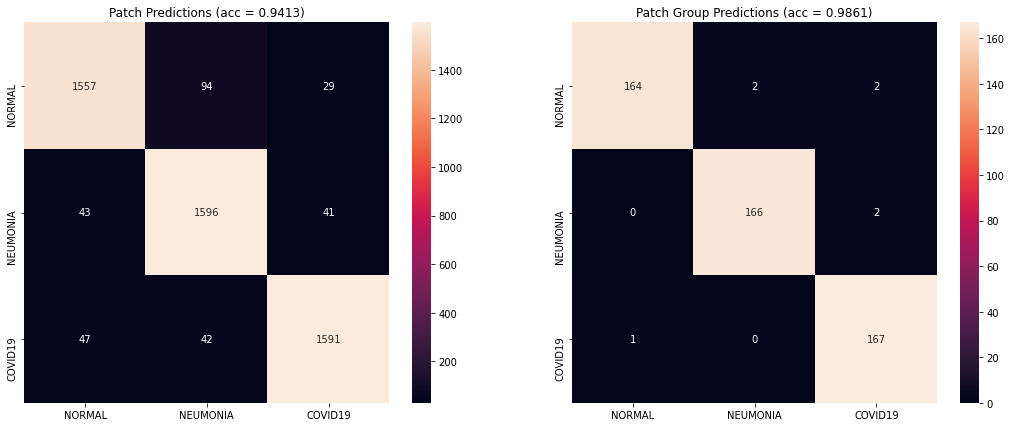

In [203]:
_pred_labels = pca_classifier.classify_many(feat_train, best_pca_dim, best_k)
_pred_group_labels = get_pred_group_labels(_pred_labels, train_groups)
plot_patch_and_group_confusion_matrixes(labels_train, _pred_labels, train_group_labels, _pred_group_labels)

### results of best version on test set

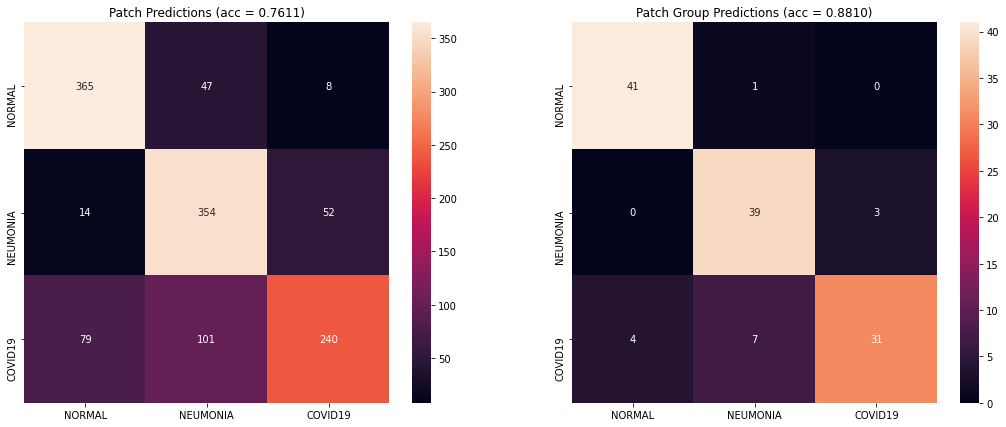

In [204]:
_pred_labels = pca_classifier.classify_many(feat_test, best_pca_dim, best_k)
_pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
plot_patch_and_group_confusion_matrixes(labels_test, _pred_labels, test_group_labels, _pred_group_labels)

## Strategy 2: MLP (1 hidden layer)

In [193]:
best_hidden_layer_size = None
best_group_acc = 0
best_clf = None
for hidden_layer_size in (5, 10, 20, 30, 40, 50, 80, 120):
    clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,),
                        random_state=1,
                        max_iter=500).fit(feat_train, labels_train)
    _pred_labels = clf.predict(feat_test)
    _pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
    _patch_acc = get_accuracy(_pred_labels, labels_test)
    _group_acc = get_accuracy(_pred_group_labels, test_group_labels)
    print('---- hidden layer size = %d, patch acc = %.6f, patch group acc = %.6f ----' % (
        hidden_layer_size, _patch_acc, _group_acc))
    if _group_acc > best_group_acc:
        best_group_acc = _group_acc
        best_hidden_layer_size = hidden_layer_size
        best_clf = clf

---- hidden layer size = 5, patch acc = 0.873016, patch group acc = 0.960317 ----
---- hidden layer size = 10, patch acc = 0.876190, patch group acc = 0.952381 ----
---- hidden layer size = 20, patch acc = 0.874603, patch group acc = 0.960317 ----
---- hidden layer size = 30, patch acc = 0.888889, patch group acc = 0.968254 ----
---- hidden layer size = 40, patch acc = 0.896825, patch group acc = 0.976190 ----
---- hidden layer size = 50, patch acc = 0.886508, patch group acc = 0.960317 ----
---- hidden layer size = 80, patch acc = 0.888889, patch group acc = 0.952381 ----
---- hidden layer size = 120, patch acc = 0.893651, patch group acc = 0.944444 ----


In [214]:
best_hidden_layer_size

40

### results of best version on training set

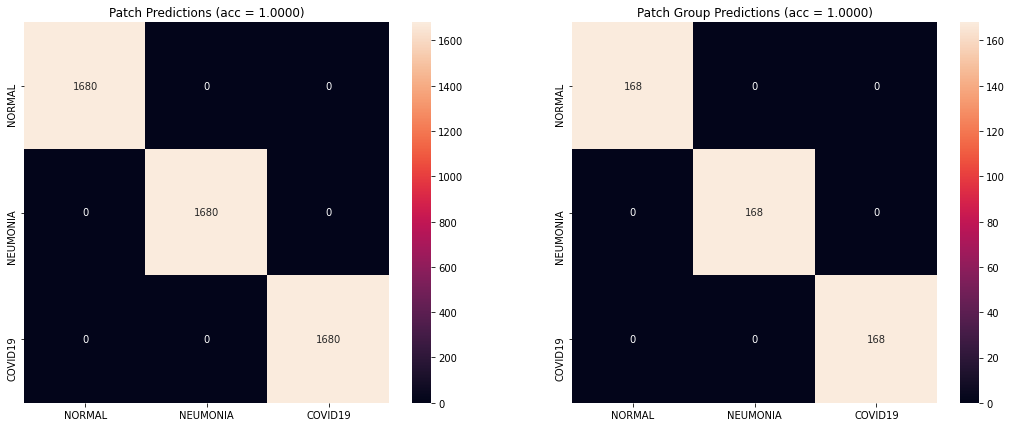

In [194]:
_pred_labels = best_clf.predict(feat_train)
_pred_group_labels = get_pred_group_labels(_pred_labels, train_groups)
plot_patch_and_group_confusion_matrixes(labels_train, _pred_labels, train_group_labels, _pred_group_labels)

### results of best version on test set

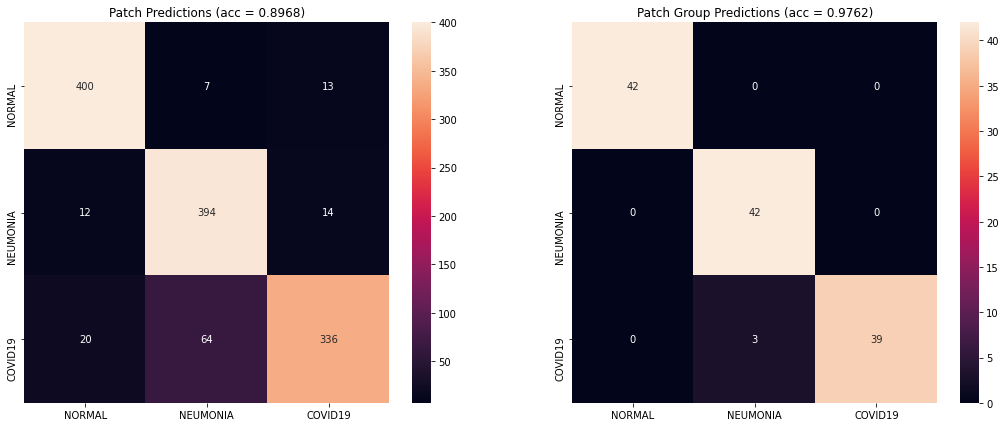

In [195]:
_pred_labels = best_clf.predict(feat_test)
_pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
plot_patch_and_group_confusion_matrixes(labels_test, _pred_labels, test_group_labels, _pred_group_labels)

## Strategy 3: SVM (support vector machine)

In [210]:
best_clf = None
best_group_acc = 0

### try different kernels and settings

In [211]:
for svc in [
    SVC(kernel='linear'),
    SVC(kernel='poly', degree=2, gamma='scale'),
    SVC(kernel='poly', degree=2, gamma='auto'),
    SVC(kernel='poly', degree=3, gamma='scale'),
    SVC(kernel='poly', degree=3, gamma='auto'),
    SVC(kernel='poly', degree=4, gamma='scale'),
    SVC(kernel='poly', degree=4, gamma='auto'),
    SVC(kernel='rbf', gamma='scale'),
    SVC(kernel='rbf', gamma='auto'),
    SVC(kernel='sigmoid', gamma='scale'),
    SVC(kernel='sigmoid', gamma='auto'),
]:
    clf = svc.fit(feat_train, labels_train)
    _pred_labels = clf.predict(feat_test)
    _pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
    _patch_acc = get_accuracy(_pred_labels, labels_test)
    _group_acc = get_accuracy(_pred_group_labels, test_group_labels)
    print('---- patch acc = %.6f, patch group acc = %.6f ----' % (_patch_acc, _group_acc))
    print(svc)
    if _group_acc > best_group_acc:
        best_group_acc = _group_acc
        best_clf = clf    

---- patch acc = 0.903968, patch group acc = 0.960317 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- patch acc = 0.799206, patch group acc = 0.865079 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- patch acc = 0.799206, patch group acc = 0.865079 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- patch acc = 0.769048, patch group acc = 0.801587 ----
SVC(C=1.0,

### results of best version on training set

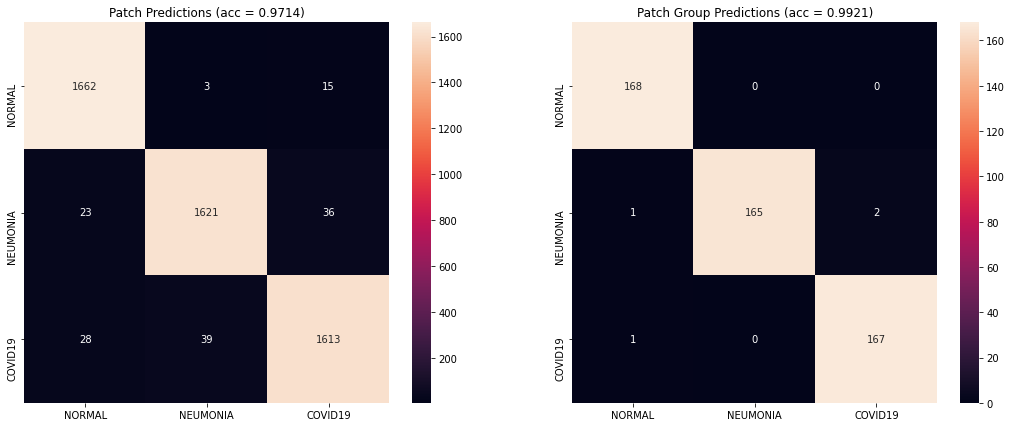

In [212]:
_pred_labels = best_clf.predict(feat_train)
_pred_group_labels = get_pred_group_labels(_pred_labels, train_groups)
plot_patch_and_group_confusion_matrixes(labels_train, _pred_labels, train_group_labels, _pred_group_labels)

### results of best version on test set

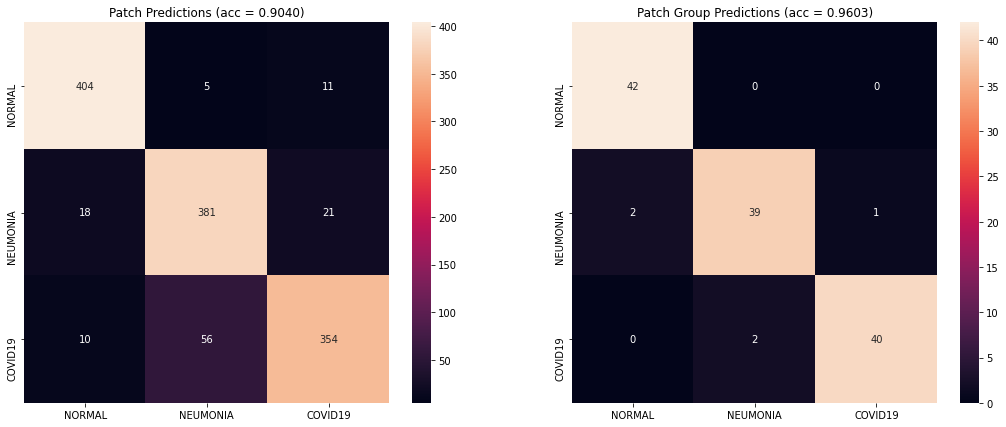

In [213]:
_pred_labels = best_clf.predict(feat_test)
_pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
plot_patch_and_group_confusion_matrixes(labels_test, _pred_labels, test_group_labels, _pred_group_labels)

## Strategy 4: PCA + MLP (0 or 1 hidden layers)

In [236]:
best_group_acc = 0
best_clf = None
best_pca = None

for pca_dim in (20, 30, 40, 50, 60, 100):    
    pca = PCA(n_components=pca_dim)
    X_train = pca.fit_transform(feat_train)
    for hidden_layers in ((), (5,), (10,)):
        clf = MLPClassifier(hidden_layer_sizes=hidden_layers,
                            random_state=1,
                            max_iter=550).fit(X_train, labels_train)
        _pred_labels = clf.predict(pca.transform(feat_test))
        _pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
        _patch_acc = get_accuracy(_pred_labels, labels_test)
        _group_acc = get_accuracy(_pred_group_labels, test_group_labels)
        print('---- pca_dim = %d, hidden layers = %s, patch acc = %.6f, patch group acc = %.6f ----' % (
            pca_dim, str(hidden_layers), _patch_acc, _group_acc))
        if _group_acc > best_group_acc:
            best_group_acc = _group_acc
            best_pca = pca
            best_clf = clf

---- pca_dim = 20, hidden layers = (), patch acc = 0.869048, patch group acc = 0.928571 ----
---- pca_dim = 20, hidden layers = (5,), patch acc = 0.873016, patch group acc = 0.936508 ----
---- pca_dim = 20, hidden layers = (10,), patch acc = 0.875397, patch group acc = 0.944444 ----
---- pca_dim = 30, hidden layers = (), patch acc = 0.875397, patch group acc = 0.944444 ----
---- pca_dim = 30, hidden layers = (5,), patch acc = 0.877778, patch group acc = 0.960317 ----
---- pca_dim = 30, hidden layers = (10,), patch acc = 0.849206, patch group acc = 0.912698 ----
---- pca_dim = 40, hidden layers = (), patch acc = 0.873016, patch group acc = 0.936508 ----
---- pca_dim = 40, hidden layers = (5,), patch acc = 0.876190, patch group acc = 0.944444 ----
---- pca_dim = 40, hidden layers = (10,), patch acc = 0.840476, patch group acc = 0.896825 ----
---- pca_dim = 50, hidden layers = (), patch acc = 0.892857, patch group acc = 0.960317 ----
---- pca_dim = 50, hidden layers = (5,), patch acc = 0.

/home/pamessina/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (550) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [238]:
for pca_dim in (50, 55, 58, 60, 62, 65, 70):
    pca = PCA(n_components=pca_dim)
    X_train = pca.fit_transform(feat_train)    
    for hidden_layers in ((), (3,), (4,), (5,), (6,)):
        clf = MLPClassifier(hidden_layer_sizes=hidden_layers,
                            random_state=1,
                            max_iter=550).fit(X_train, labels_train)
        _pred_labels = clf.predict(pca.transform(feat_test))
        _pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
        _patch_acc = get_accuracy(_pred_labels, labels_test)
        _group_acc = get_accuracy(_pred_group_labels, test_group_labels)
        print('---- pca_dim = %d, hidden layers = %s, patch acc = %.6f, patch group acc = %.6f ----' % (
            pca_dim, str(hidden_layers), _patch_acc, _group_acc))
        if _group_acc > best_group_acc:
            best_group_acc = _group_acc
            best_pca = pca
            best_clf = clf

---- pca_dim = 50, hidden layers = (), patch acc = 0.887302, patch group acc = 0.968254 ----
---- pca_dim = 50, hidden layers = (3,), patch acc = 0.892063, patch group acc = 0.968254 ----
---- pca_dim = 50, hidden layers = (4,), patch acc = 0.880159, patch group acc = 0.944444 ----
---- pca_dim = 50, hidden layers = (5,), patch acc = 0.869048, patch group acc = 0.936508 ----
---- pca_dim = 50, hidden layers = (6,), patch acc = 0.875397, patch group acc = 0.952381 ----
---- pca_dim = 55, hidden layers = (), patch acc = 0.888095, patch group acc = 0.976190 ----
---- pca_dim = 55, hidden layers = (3,), patch acc = 0.880952, patch group acc = 0.944444 ----
---- pca_dim = 55, hidden layers = (4,), patch acc = 0.886508, patch group acc = 0.952381 ----
---- pca_dim = 55, hidden layers = (5,), patch acc = 0.889683, patch group acc = 0.960317 ----
---- pca_dim = 55, hidden layers = (6,), patch acc = 0.874603, patch group acc = 0.936508 ----
---- pca_dim = 58, hidden layers = (), patch acc = 0.8

In [240]:
best_pca, best_clf

(PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(5,), learning_rate='constant',
               learning_rate_init=0.001, max_fun=15000, max_iter=550,
               momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
               power_t=0.5, random_state=1, shuffle=True, solver='adam',
               tol=0.0001, validation_fraction=0.1, verbose=False,
               warm_start=False))

### results of best version on training set

In [241]:
X_train = best_pca.transform(feat_train)

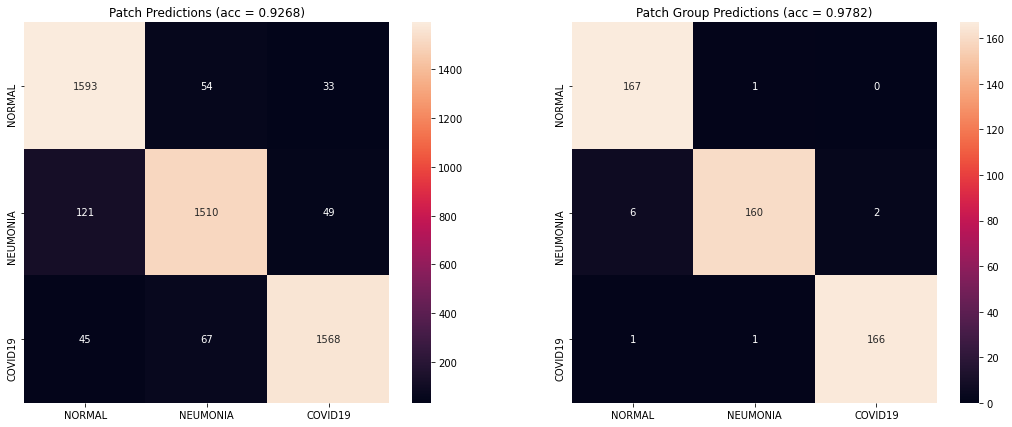

In [242]:
_pred_labels = best_clf.predict(X_train)
_pred_group_labels = get_pred_group_labels(_pred_labels, train_groups)
plot_patch_and_group_confusion_matrixes(labels_train, _pred_labels, train_group_labels, _pred_group_labels)

### results of best version on test set

In [243]:
X_test = best_pca.transform(feat_test)

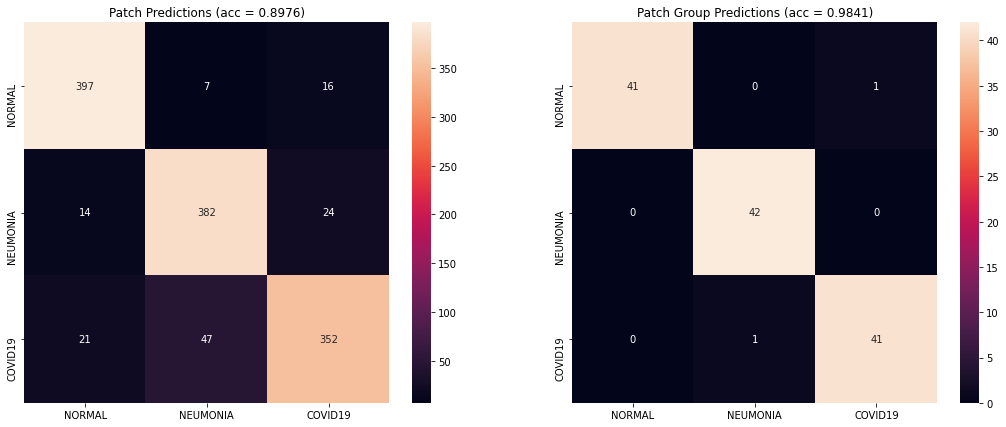

In [244]:
_pred_labels = best_clf.predict(X_test)
_pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
plot_patch_and_group_confusion_matrixes(labels_test, _pred_labels, test_group_labels, _pred_group_labels)

## Strategy 5: PCA + SVM

In [245]:
best_group_acc = 0
best_clf = None
best_pca = None

for pca_dim in (20, 30, 40, 50, 60, 100):    
    pca = PCA(n_components=pca_dim)
    X_train = pca.fit_transform(feat_train)    
    
    for svc in [
        SVC(kernel='linear'),
        SVC(kernel='poly', degree=2),
        SVC(kernel='poly', degree=3),
        SVC(kernel='rbf'),
        SVC(kernel='sigmoid'),
    ]:
        clf = svc.fit(X_train, labels_train)
        _pred_labels = clf.predict(pca.transform(feat_test))
        _pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
        _patch_acc = get_accuracy(_pred_labels, labels_test)
        _group_acc = get_accuracy(_pred_group_labels, test_group_labels)
        print('---- pca_dim = %d, patch acc = %.6f, patch group acc = %.6f ----' % (
            pca_dim, _patch_acc, _group_acc))
        print(svc)
        if _group_acc > best_group_acc:
            best_group_acc = _group_acc
            best_clf = clf
            best_pca = pca

---- pca_dim = 20, patch acc = 0.866667, patch group acc = 0.928571 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- pca_dim = 20, patch acc = 0.733333, patch group acc = 0.777778 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- pca_dim = 20, patch acc = 0.800794, patch group acc = 0.849206 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- pca_dim = 20, patch a

---- pca_dim = 100, patch acc = 0.791270, patch group acc = 0.865079 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- pca_dim = 100, patch acc = 0.786508, patch group acc = 0.833333 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- pca_dim = 100, patch acc = 0.893651, patch group acc = 0.936508 ----
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
---- pca_dim = 100, patch 

In [247]:
best_group_acc, best_pca, best_clf

(0.9603174603174603,
 PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False))

### results of best version on training set

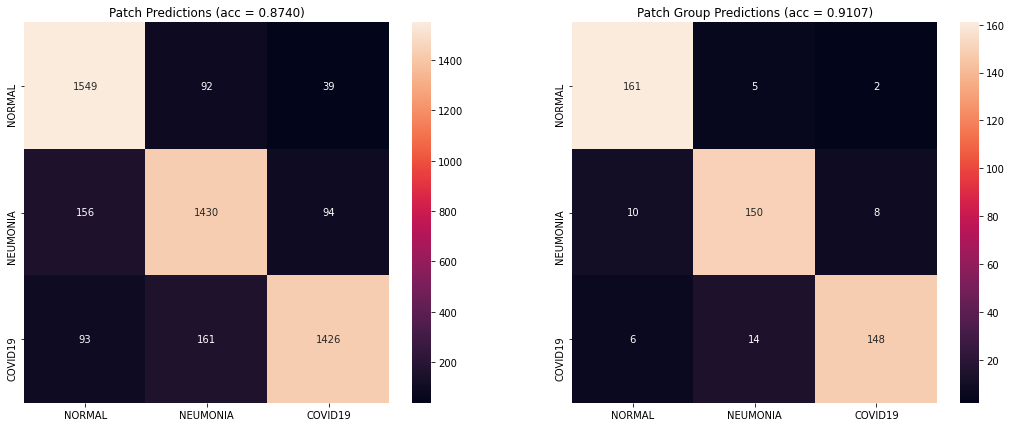

In [248]:
X_train = best_pca.transform(feat_train)
_pred_labels = best_clf.predict(X_train)
_pred_group_labels = get_pred_group_labels(_pred_labels, train_groups)
plot_patch_and_group_confusion_matrixes(labels_train, _pred_labels, train_group_labels, _pred_group_labels)

### results of best version on test set

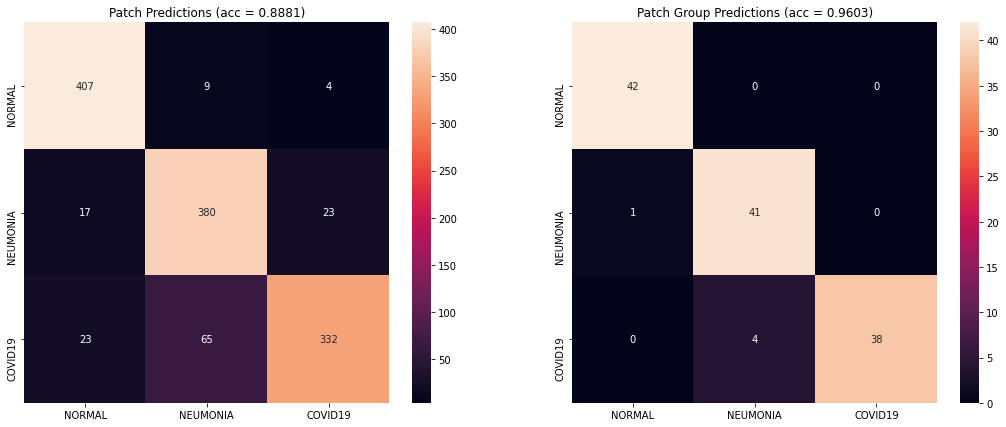

In [249]:
X_test = best_pca.transform(feat_test)
_pred_labels = best_clf.predict(X_test)
_pred_group_labels = get_pred_group_labels(_pred_labels, test_groups)
plot_patch_and_group_confusion_matrixes(labels_test, _pred_labels, test_group_labels, _pred_group_labels)